In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, shape
import geopandas as gpd
import pickle

# Import custom functions from `scripts` folder
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from scripts.clean_tweets import geometrize_tweets, convert_shapefile_crs, find_frequencies

np.random.seed(42)
pd.set_option('display.max_columns', 999)

# Loading data

In [2]:
# Read 2014/2015 Bogota tweets
bo14 = pd.read_csv('../data/tweets/bo_2014.csv')
bo15 = pd.read_csv('../data/tweets/bo_2015.csv')

In [3]:
# Convert to GeoDataFrame based on lat/lon
bo14 = geometrize_tweets(bo14)
bo15 = geometrize_tweets(bo15)

In [4]:
# Read shapefiles
bogota = gpd.read_file('../data/shapefiles/bogota_shapefiles/shp_secciondata.shp')
elbronx = gpd.read_file('../data/shapefiles/bogota_neighborhood_shapefiles/barrios_bronx.shp')

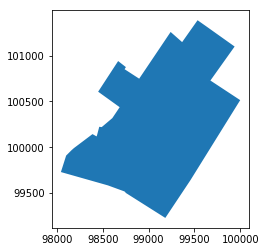

In [5]:
# Visualize El Bronx; note that the CRS is not in WGS84 format
elbronx.plot();

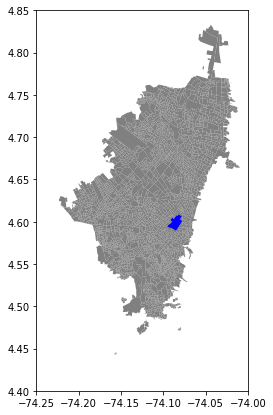

In [6]:
# Convert elbronx to WGS84, then visualize El Bronx on top of Bogota
elbronx = convert_shapefile_crs(elbronx)

fig, ax = plt.subplots(figsize=(10, 7))
bogota.plot(ax=ax, color='gray')
elbronx.plot(ax=ax, color='blue')
ax.set_ylim(4.4, 4.85)
ax.set_xlim(-74.25, -74);

# Assign tracts to tweets

We are interested in two features:

1. Whether or not a tweet is generated from El Bronx.
1. Whether or not a tweet is within 0.5 miles of El Bronx

## 1: El Bronx

In [7]:
# Compute a spatial join between tweets and elbronx
bo14_bronx = gpd.sjoin(bo14, elbronx, how='left', op='intersects')
bo15_bronx = gpd.sjoin(bo15, elbronx, how='left', op='intersects')

/scratch/public/jsp/twitter-and-displacement/.env/lib/python3.7/site-packages/geopandas/tools/sjoin.py:56: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'proj': 'tmerc', 'lat_0': 4.680486111, 'lon_0': -74.14659167, 'k': 1, 'x_0': 92334.879, 'y_0': 109320.965, 'a': 6380687, 'b': 6359293.764473119, 'units': 'm', 'no_defs': True})
  '(%s != %s)' % (left_df.crs, right_df.crs))


In [8]:
# If the tweet point lies in the tract geometry, `br_diss` is not null.
bo14['bronx'] = ~bo14_bronx['br_diss'].isnull()
bo15['bronx'] = ~bo15_bronx['br_diss'].isnull()

In [9]:
print(f"{bo14['bronx'].sum()} of {len(bo14)} 2014 tweets are from El Bronx")
print(f"{bo15['bronx'].sum()} of {len(bo15)} 2015 tweets are from El Bronx")

41970 of 10949137 2014 tweets are from El Bronx
47026 of 4056214 2015 tweets are from El Bronx


## 2: Within 0.5 miles of El Bronx

Our next objective is to find tweets within 0.5 miles of El Bronx. Instead of creating a buffer around El Bronx, we can instead create a 0.5 mile buffer around each tweet's location, then find all tweets that overlap with the geometry of El Bronx. The leftmost picture below illustrates this approach; we can consider the square to be the geometry of El Bronx, and the circle to be the geometry of a single tweet.

![](https://geopandas.readthedocs.io/en/latest/_images/overlay_operations.png)

Each degree of latitude is approximately 69 miles apart. For longitude to miles, at a given latitude, the conversion is as follows ([source](https://gis.stackexchange.com/questions/142326/calculating-longitude-length-in-miles)):

`1 degree of longitude` = `cosine(latitude in decimal)` * `length of degree (miles) at equator`

Then we compute:

In [10]:
# -74.8 is roughly the median latitude of El Bronx
np.cos(-74.8) * 69.172

57.15940333782036

1 degree of latitude is 69 miles, and 1 degree of longitude is 57.1594 miles. This means that 0.5 miles is represented by $\frac{0.5}{69} \approx 0.007246$ degrees of latitude and $\frac{0.5}{57.1594} \approx 0.008747$ degrees of longitude. A roughly 0.5 mile buffer can be established by creating a buffer of ~0.008 degrees around each tweet. 

In [12]:
BUFFER = 0.008

# Build dataframe containing buffer around each tweet
bo14_buffer, bo15_buffer = bo14.copy(), bo15.copy()
bo14_buffer['geometry'] = bo14_buffer.buffer(BUFFER)
bo15_buffer['geometry'] = bo15_buffer.buffer(BUFFER)

In [13]:
# Compute a spatial join between tweets and elbronx + buffer
bo14_buffer_joined = gpd.sjoin(bo14_buffer, elbronx, how='left', op='intersects')
bo15_buffer_joined = gpd.sjoin(bo15_buffer, elbronx, how='left', op='intersects')

In [14]:
# If the tweet buffer intersects the tract geometry, `br_diss` is not null.
bo14['buffer'] = ~bo14_buffer_joined['br_diss'].isnull()
bo15['buffer'] = ~bo15_buffer_joined['br_diss'].isnull()

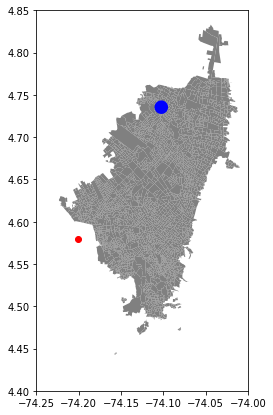

In [15]:
# Visualize one expanded tweet (blue), one regular tweet (red):
fig, ax = plt.subplots(figsize=(10, 7))
bogota.plot(ax=ax, color='gray')
bo15_buffer.sample(n=1).plot(ax=ax, color='blue')
bo15.sample(n=1).plot(ax=ax, color='red')
ax.set_ylim(4.4, 4.85)
ax.set_xlim(-74.25, -74);

In [16]:
print(f"{(bo14['buffer'] & ~bo14['bronx']).sum()} of {len(bo14)} 2014 tweets are from the buffer")
print(f"{(bo15['buffer'] & ~bo15['bronx']).sum()} of {len(bo15)} 2015 tweets are from the buffer")

271335 of 10949137 2014 tweets are from the buffer
119850 of 4056214 2015 tweets are from the buffer


In [17]:
# Add hour for future analysis
bo14['hour'] = pd.to_datetime(bo14['created_at'] // 1000, unit='s').dt.hour
bo15['hour'] = pd.to_datetime(bo15['created_at'] // 1000, unit='s').dt.hour

In [2]:
### Save bo14 and bo15 for easy loading
# with open('../data/bo14_bronx.pkl', 'wb') as file:
#     pickle.dump(bo14, file)
# with open('../data/bo15_bronx.pkl', 'wb') as file:
#     pickle.dump(bo15, file)
    
with open('../data/bo14_bronx.pkl', 'rb') as file:
    bo14 = pickle.load(file)
with open('../data/bo15_bronx.pkl', 'rb') as file:
    bo15 = pickle.load(file)

# Analysis of "La L" and "El Bronx" frequencies

We first observe all tweets (regardless of timestamp). For "La L", to avoid any overlap with other words, we check for two patterns:

- "La L " (with a whitespace following "L")
- "La L"  (if "L" is the last character in the tweet)

We also make our analysis case-insensitive.

In [3]:
# All tweets sent from El Bronx
print('{} of {} tweets sent from El Bronx in 2014 contain "el bronx"'.format(
    *find_frequencies(bo14.loc[bo14['bronx'], 'text'], r'el bronx')))
print('{} of {} tweets sent from El Bronx in 2015 contain "el bronx"'.format(
    *find_frequencies(bo15.loc[bo15['bronx'], 'text'], r'el bronx')))
print()
print('{} of {} tweets sent from El Bronx in 2014 contain "la l"'.format(
    *find_frequencies(bo14.loc[bo14['bronx'], 'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from El Bronx in 2015 contain "la l"'.format(
    *find_frequencies(bo15.loc[bo15['bronx'], 'text'], r'(la l[\s.,-])|(la l$)')))

15 of 41970 tweets sent from El Bronx in 2014 contain "el bronx"
4 of 47026 tweets sent from El Bronx in 2015 contain "el bronx"



/scratch/public/jsp/twitter-and-displacement/02_analysis/scripts/clean_tweets.py:85: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  num_matches = series.str.contains(pat, case=case).sum()


3 of 41970 tweets sent from El Bronx in 2014 contain "la l"
2 of 47026 tweets sent from El Bronx in 2015 contain "la l"


In [4]:
# All tweets made from 0.5 mile buffer
print('{} of {} tweets sent from buffer in 2014 contain "el bronx"'.format(
    *find_frequencies(bo14.loc[(bo14['buffer']) & (~bo14['bronx']), 'text'], r'el bronx')))
print('{} of {} tweets sent from buffer in 2015 contain "el bronx"'.format(
    *find_frequencies(bo15.loc[(bo15['buffer']) & (~bo15['bronx']), 'text'], r'el bronx')))
print()
print('{} of {} tweets sent from buffer in 2014 contain "la l"'.format(
    *find_frequencies(bo14.loc[(bo14['buffer']) & (~bo14['bronx']), 'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from buffer in 2015 contain "la l"'.format(
    *find_frequencies(bo15.loc[(bo15['buffer']) & (~bo15['bronx']), 'text'], r'(la l[\s.,-])|(la l$)')))

9 of 271335 tweets sent from buffer in 2014 contain "el bronx"
5 of 119850 tweets sent from buffer in 2015 contain "el bronx"

8 of 271335 tweets sent from buffer in 2014 contain "la l"
1 of 119850 tweets sent from buffer in 2015 contain "la l"


Next, we look at the subset of times 8pm-4am (during which we think that people are mostly at home only if they are residents):

In [5]:
# All tweets sent from El Bronx between 8pm-4am
print('{} of {} tweets sent from El Bronx in 2014 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo14.loc[(bo14['bronx']) & ((bo14['hour'] >= 18) | (bo14['hour'] <= 4)), 
                               'text'], r'el bronx')))
print('{} of {} tweets sent from El Bronx in 2015 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo15.loc[(bo15['bronx']) & ((bo15['hour'] >= 18) | (bo15['hour'] <= 4)), 
                               'text'], r'el bronx')))
print()
print('{} of {} tweets sent from El Bronx in 2014 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo14.loc[(bo14['bronx']) & ((bo14['hour'] >= 18) | (bo14['hour'] <= 4)), 
                               'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from El Bronx in 2015 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo15.loc[(bo15['bronx']) & ((bo15['hour'] >= 18) | (bo15['hour'] <= 4)), 
                               'text'], r'(la l[\s.,-])|(la l$)')))

9 of 25341 tweets sent from El Bronx in 2014 between 8pm-4am contain "el bronx"
3 of 29297 tweets sent from El Bronx in 2015 between 8pm-4am contain "el bronx"

1 of 25341 tweets sent from El Bronx in 2014 between 8pm-4am contain "la l"
0 of 29297 tweets sent from El Bronx in 2015 between 8pm-4am contain "la l"


In [6]:
# All tweets sent from buffer between 8pm-4am
print('{} of {} tweets sent from buffer in 2014 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo14.loc[((bo14['buffer']) & (~bo14['bronx'])) & 
                               ((bo14['hour'] >= 18) | (bo14['hour'] <= 4)), 
                               'text'], r'el bronx')))
print('{} of {} tweets sent from buffer in 2015 between 8pm-4am contain "el bronx"'.format(
    *find_frequencies(bo15.loc[((bo15['buffer']) & (~bo15['bronx'])) & 
                               ((bo15['hour'] >= 18) | (bo15['hour'] <= 4)), 
                               'text'], r'el bronx')))
print()
print('{} of {} tweets sent from buffer in 2014 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo14.loc[((bo14['buffer']) & (~bo14['bronx'])) & 
                               ((bo14['hour'] >= 18) | (bo14['hour'] <= 4)), 
                               'text'], r'(la l[\s.,-])|(la l$)')))
print('{} of {} tweets sent from buffer in 2015 between 8pm-4am contain "la l"'.format(
    *find_frequencies(bo15.loc[((bo15['buffer']) & (~bo15['bronx'])) & 
                               ((bo15['hour'] >= 18) | (bo15['hour'] <= 4)), 
                               'text'], r'(la l[\s.,-])|(la l$)')))

3 of 166123 tweets sent from buffer in 2014 between 8pm-4am contain "el bronx"
3 of 71986 tweets sent from buffer in 2015 between 8pm-4am contain "el bronx"

4 of 166123 tweets sent from buffer in 2014 between 8pm-4am contain "la l"
1 of 71986 tweets sent from buffer in 2015 between 8pm-4am contain "la l"


For context, here are the number of total tweets sent in Bogota in each of 2014 and 2015:

In [7]:
print(f'{len(bo14)} tweets in Bogota in 2014')
print(f'{len(bo15)} tweets in Bogota in 2015')

10949137 tweets in Bogota in 2014
4056214 tweets in Bogota in 2015
